Notebook looking to reproduce plots from Ch 3 of Matt Pyle's thesis

Ch 3 ("Lump Element TES Dynamics") has a few main oversimplifactions. It treats the channel (line of many TES's) as a single lump TES with volume equal to the total volume of the line. In real systems, major effects:

1. Temperature gradient across TES's - causes differences in response and decouples the slope of the Pbath/VB curve from alpha or the intrinsic temperature width (expected changes from Ch 3 predictions, but not the only ones observed - others more problematic)


2. Treatment in Ch 3 also ignores "absorber"-like effects from thermal coupling of TES to fin connectors, fin connectors to substrate, *and* TES to substrate (this treatment only looks at TES to substrate). Found that heat capacity and electron/phonon coupling is dominated by the fin connectors. 

    Introduces slightly new scaling law to the bath power, vtes --> (vtes + epsilon_fc*v_fin) - now the volume of the fins is also included, with an efficiency factor epsilon_fc (best estimate epsilon_fc ~ 70% at operating point)

    In general epsilon_fc expected to vary with Tc and Tbath, amount of variation dependent on the cause of the masking. If caused by thermal gradient along the fin connector, expect epsilon_fc -> as Tc -> 0. Or, if epsilon_fc is caused by carrier density decrease from "proximity effect," then should be largely independent of Tc

    More detailed treatment in Ch 4 assumes epsilon_fc is identical to suppression in heat capacity 


3. Internal TES inhomogeneities - spatial temperature fluctuations inside W. Flucutations increase over time (until gradient within TES balances the feedback effect causing the variation). Can be minimized or eliminated by design choices.

### other notes ###

Matt expects $\partial I / \partial V$ studies of increasing complexity in future, for reasons of "decreased TES length/lower Tc (no phase seperation) and new squid electronics." 



Poles of dIdV and dIdP are the same, no matter the complexity of the M matrix (`_getDIdP` below) (which does get much more complicated when expanding thermal degrees of freedom). 

In [123]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

import sys
sys.path.append('../optimal_filter')
from optimal_filter_utils import *

In [124]:
# trace parameters
N = 16*4096 # no. of samples
T = 6 # sampling half period (s)
idx, tk, wn = get_idx_tk_wn(N = N, T = T)

wspace = np.geomspace(1e2, 2e7, 250)
fn = wspace/2/np.pi

In [125]:
# system parameters

Sigma = 0.32e9 # electron/phonon coupling constant (W/K^5 m^3) (or is it 0.32e-12???)
n_therm = 5 # thermal conduction power law exponent
vtes = 1.7e-14 # TES volume (m^3) (17,000 um^3)
rhow = 1.32e-7 # W film resistivity (Ohm m)
Rn = 700e-3 # normal resistance of single phonon channel (Ohm)
fsc = 2.5 # heat capacity increase due to superconducting/normal phase change
gammaw = 108 # W heat capacity coefficient (J/K^2 m^3)
Tc = 80e-3 # transition temp (K)
dTc90_10 = 0.5e-3 # transition width from 10% of normal to 90% of normal (K)
ltes = 220e-9 # TES length in direction of current flow (m)
nchan = 4 # number of phonon channels
Tbath = 0.015 #Tc*0.2 # 0.9?

# electronics params
Rbias = 1.2e3 # Ohm
Tbias = 300 # K
Rfeedback = 1.2e3 # Ohm
Rs = 20e-3 # Ohm
Ts = 0.6 # K
Rp = 1e-6 # Ohm
Tp = 40e-3 # K
Lsquid = 250e-9 # SQUID inductance + parasitic inductance of wiring and detector (H)

# derived params

# alpha - relative R/T change at operating temp (dR/R)/(dT/T)
alpha = (np.log(9)*Tc/2/dTc90_10) # from fxnal form below

# beta - relative R/I change at operating temp (dR/R)/(dI/I)
beta = 0.063 # estimated from didv fits (Ch C)
#beta = 1.1 # estimated from fig 3.23 from Matt's thesis, Tc = 80 mK
# although at beginning of Ch 4, says some matching to behavior of device w/ beta ~ 0.3


Rl = Rp + Rs # Thevenin equivalent resistance of shunt and Rp (exact equivalent: convert shunt/current source into voltage source w/ voltage VB = IB*Rs)
R0 = Rn + Rp + Rs # total operating-point resistance

Cw = fsc*gammaw*vtes*Tc # TES total heat capacity (J/K)

# (Pyle eq (3.1)) proportionality to vtes and reduction to intrinsic phonon/electron coupling constant Sigma was measured during IbIs measurements at different TSi (assume W phonon system has T~Tbath)
Pbath = Sigma*vtes*(Tc**n_therm - Tbath**n_therm) # bath thermal power (W)

G = n_therm*Sigma*vtes*Tc**(n_therm - 1) # differential thermal conductance dPbath/dT (W/K)

# Johnson-noise equivalent effective temperature (resistance-weighted) (Pyle eq (3.22) and (3.23))
Tstar = (Rs*Ts + Rp*Tp + Rn*Tc)/R0 # K
# assumes frequencies below wL/R (substituting |Ztot|^2 for R0^2 in derivation of current noise 4kb*Tstar/R0)

# Irwin's low frequency loop gain parameter
Ell = Pbath*alpha/G/Tc

# worst-approximation electrothermal feedback fall time
tau_eff = Cw/G/(Ell + 1) # 
# this formula (Pyle eq (3.5)) generalized to account for the effects of both beta and Rl (in the L->0 limit) in Pyle eq 3.14

# constants 
hbaroverkb = 7.638235233106251e-12 # (Kelvin-sec)
kb = 1.38064852e-23 # J/K

In [126]:
print(f'Pbath = {Pbath*1e12:.5g} pW')

Pbath = 17.822 pW


In [127]:
G*Ell/Cw

106639.95522373197

In [128]:
alpha, beta

(175.77796618689754, 0.063)

In [129]:
Ell

35.14744617969682

In [130]:
# R(T) curve parameterization (according to Matt seems to get the qualitative job done)

def rho_TES(J, T, rho_n = Rn/vtes, eta = 1):
    thing = (eta/1.76)*np.sqrt(hbaroverkb*Rn*Tc/Cw)*J
    return rho_n*(1 + np.tanh((T - Tc - thing**(2/3))*np.log(9)/dTc90_10))/2

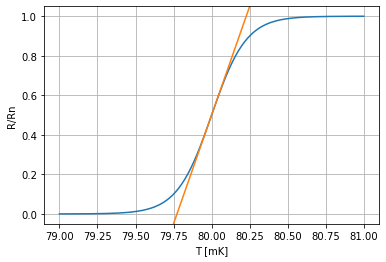

In [131]:
def plot_T():
    Tvals = Tc + 2*dTc90_10*np.linspace(-1, 1, 200)
    rho_vals = vtes*rho_TES(0, Tvals)/Rn

    plt.figure()
    plt.grid()
    plt.plot(Tvals*1e3, rho_vals, label = 'model')
    wind = plt.axis()
    plt.plot(Tvals*1e3, 1/2 + alpha*(Tvals-Tc)/Tc, label = 'tangent')
    plt.axis(wind)
    plt.xlabel('T [mK]')
    plt.ylabel('R/Rn')
    plt.show()

plot_T()

In [132]:
Ftfn_ballistic = lambda T: (1 + (Tbath/T)**n_therm)/2
Ftfn_diffusive = lambda T: ((n_therm/(2*n_therm+1)))*((Tbath/T)**(2*n_therm + 1) - 1)/((Tbath/T)**n_therm - 1)
Ftfn_here = Ftfn_ballistic(Tc)

# thermal noise across connection to bath
SpTFN = 4*kb*Tc**2*G*Ftfn_here

# Johnson noise through circuit
SpRl = 4*kb*(Tc**2)*G*(Tstar*(1 - Tbath**n_therm/Tc**n_therm)/Tc/n_therm)*(1 + wspace**2*(Cw/G/(1- Ell))**2)

# Johnson noise in TES
SpRtes = 4*kb*(Tc**2)*G*((1 - Tbath**n_therm/Tc**n_therm)/n_therm/Ell**2)*((1 + beta)**2)*(1 + wspace**2*(Cw/G)**2)

# nominal total
wstar = (G*Ell/Cw/(1+beta))*np.sqrt((Tstar/Tc + n_therm*Ftfn_here/(1 - (Tbath/Tc)**n_therm))/(1 + Tstar/(Tc*(1+beta)**2)))
Sp = 4*kb*Tc**2*G*(Ftfn_here + Tstar*(1 - Tbath**n_therm/Tc**n_therm)/Tc/n_therm)*(1 + wspace**2/wstar**2)
Sp_n = 4*kb*Tc**2*G*(Ftfn_here + Tstar*(1 - Tbath**n_therm/Tc**n_therm)/Tc/n_therm)*(1 + wn**2/wstar**2)

In [133]:
(G*Ell/Cw/(1+beta)), np.sqrt((Tstar/Tc + n_therm*Ftfn_here/(1 - (Tbath/Tc)**n_therm))/(1 + Tstar/(Tc*(1+beta)**2)))

(100319.8073600489, 1.341847185606815)

In [134]:
(Tstar*(1 - Tbath**n_therm/Tc**n_therm)/Tc/n_therm), Ftfn_here, Ftfn_diffusive(Tc)

(0.23605620504806932, 0.5001158714294434, 0.45465081204732394)

In [135]:
Cw

3.6720000000000004e-13

In [136]:
G

1.114112e-09

In [137]:
(wstar*Cw/G)**2

1968.4624712173945

In [138]:
wstar, G*Ell/Cw/(1+beta)

(134613.85116669946, 100319.8073600489)

In [139]:
(1+beta)**2*(Tc/Tstar)/Ell**2

0.0007748058628776636

In [140]:
Tc, Tstar

(0.08, 0.09444436882726552)

In [141]:
Ell

35.14744617969682

In [142]:
np.sqrt((Tstar/Tc + n_therm*Ftfn_here/(1 - (Tbath/Tc)**n_therm))/(1 + Tstar/(Tc*(1+beta)**2)))

1.341847185606815

In [143]:
Tc

0.08

In [144]:
wstar

134613.85116669946

In [145]:
wstar/2/np.pi/1000

21.424459821816924

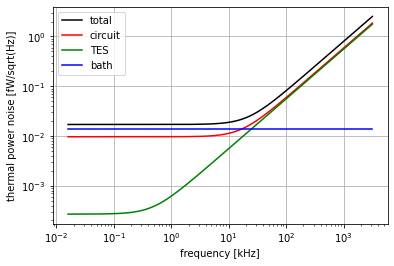

In [146]:
plt.figure()
plt.grid()
plt.xlabel('frequency [kHz]')
plt.ylabel('thermal power noise [fW/sqrt(Hz)]')
#plt.ylim(1e11, 1e17)
#plt.semilogy()
plt.loglog()
plt.plot(1e-3*fn, 1e15*np.sqrt(Sp), 'k', label = 'total')
plt.plot(1e-3*fn, 1e15*np.sqrt(SpRl), 'r', label = 'circuit')
plt.plot(1e-3*fn, 1e15*np.sqrt(SpRtes), 'g', label = 'TES')
plt.plot(1e-3*fn, 1e15*np.sqrt(SpTFN)*np.ones(fn.shape), 'b', label = 'bath')

plt.legend()

In [147]:
with open('Sp.txt', 'wb') as f:
    pickle.dump((Sp, fn), f)

In [148]:
SpTFN

1.9693485441331167e-34

In [149]:
# convert to current noise
Ibias = 1e-6 # bias current (A)
Vbias = Ibias*Rs # bias voltage
I0 = Rs*Ibias/R0


# first-order coeff matrix
M = lambda w: np.array([
    [(1j*w + Rl + Rn*(1+beta))/Lsquid, G*Ell/I0/Lsquid],
    [-I0*Rn*(2+beta)/Cw, 1j*w + G*(1-Ell)/Cw]
])

def _getdIdIP(w):
    M_1 = np.linalg.inv(M(w))
    return M_1[0,1]/Cw

def getdIdP2(w):
    return -G*Ell/((1j*w + G*(1-Ell)/Cw)*(1j*w + (Rl + R0*(1+beta))/Lsquid) + Ell*R0*G*(2+beta)/Lsquid/Cw)/Cw/I0/Lsquid

getdIdP = np.vectorize(_getdIdIP, otypes = (np.cdouble,))


dIdP = getdIdP(wspace)
dIdP_n = getdIdP(wn)

dIdP2 = getdIdP2(wspace)
dIdP2_n = getdIdP2(wn)

SITFN = SpTFN*np.abs(dIdP2)**2

# Johnson noise through circuit
SIRl = SpRl*np.abs(dIdP2)**2

# Johnson noise in TES
SIRtes = SpRtes*np.abs(dIdP2)**2

# nominal total
SI = Sp*np.abs(dIdP2)**2
SI_n = Sp_n*np.abs(dIdP2_n)**2

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


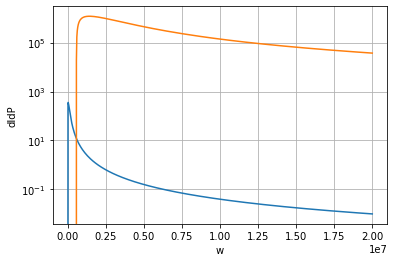

In [150]:
plt.figure()
plt.grid()
plt.xlabel('w')
plt.ylabel('dIdP')
plt.semilogy()
plt.plot(wspace, dIdP)
plt.plot(wspace, dIdP2)

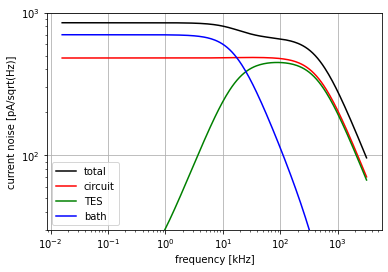

In [151]:
plt.figure()
plt.grid()
plt.xlabel('frequency [kHz]')
plt.ylabel('current noise [pA/sqrt(Hz)]')
#plt.semilogy()
plt.loglog()
plt.ylim(30, 1e3)
plt.plot(1e-3*fn, 1e12*np.sqrt(SI), 'k', label = 'total')
plt.plot(1e-3*fn, 1e12*np.sqrt(SIRl), 'r', label = 'circuit')
plt.plot(1e-3*fn, 1e12*np.sqrt(SIRtes), 'g', label = 'TES')
plt.plot(1e-3*fn, 1e12*np.sqrt(SITFN), 'b', label = 'bath')

plt.legend()

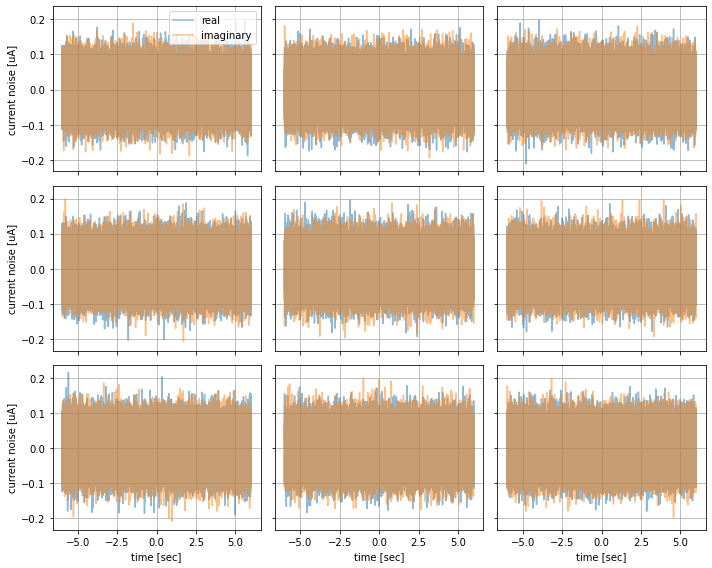

In [152]:
fig,axs = plt.subplots(nrows = 3, ncols = 3, figsize = (10, 8), sharey = True, sharex = True)

for ax in axs.flatten():
    nk = generate_noise(SI_n, T = T)
    
    ax.grid()
    ax.plot(tk, 1e6*np.real(nk), alpha = 0.5, label = 'real')
    ax.plot(tk, 1e6*np.imag(nk), alpha = 0.5, label = 'imaginary')

axs[0,0].legend()

for ax in axs[-1,:]:
    ax.set_xlabel('time [sec]')
for ax in axs[:,0]:
    ax.set_ylabel('current noise [uA]')

fig.tight_layout()


Measured dIdV curves agree very well with simulated curves at low frequencies, but results get less trustworthy at higher frequencies/toward the poles. Some explanations for differences in 